# Marathon Training Performance & Recovery Dashboard
### A Data-Driven Approach to Enhance Endurance and Optimize Recovery

## Introduction

### Objective
The Marathon Training Performance & Recovery Dashboard is a comprehensive data analysis tool designed to track, analyze, and visualize key metrics for marathon training. By leveraging interactive visualizations and performance-based insights, this tool empowers runners to optimize their training regimen, prevent overtraining, and achieve peak performance.

### Advanced Features
- **Pace Analysis**: Evaluate trends in running pace over days, weeks, and months to monitor progress.
- **Heart Rate Monitoring**: Visualize heart rate patterns to assess training intensity and cardiovascular efficiency.
- **Performance Metrics**: Generate a custom performance score combining pace, heart rate, and distance for holistic evaluation.
- **Mileage Tracking**: Track cumulative and monthly mileage to ensure gradual progression and prevent injuries.
- **Training Stress Score (TSS)**: Calculate and visualize the intensity of training sessions using duration, pace, and functional threshold power.
- **Load Balancing**: Analyze Acute Training Load (ATL) and Chronic Training Load (CTL) to ensure proper balance between effort and recovery.

### Purpose
This tool was created to:
- Assist in personal marathon training by providing actionable insights into performance and recovery.
- Demonstrate advanced skills in Python, data visualization, and user-friendly dashboard design for professional applications.

### Technology Stack
- **Programming Language**: Python
- **Data Visualization**: Plotly, Matplotlib, Seaborn
- **Data Management**: Pandas, NumPy
- **Deployment**: GitHub Pages

In [58]:
import pandas as pd
import numpy as np

# Load the CSV data
file_path = 'RunningData.csv' 

try:
    df = pd.read_csv(file_path, header=0)  # First row is used as header
    # print("Preview of raw data:")
    # print(df.head(10))  # Print the first 10 rows to check structure

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Proceed only if the DataFrame is loaded successfully
if df is not None and not df.empty:
    # Clean and process the DataFrame
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()

    # Define the cleaning function for time format
    def clean_time_format(time_str):
        if pd.isna(time_str):
            return time_str  # Return NaN as is
        parts = time_str.split(':')
        # If there are only two components (mm:ss), add "00:" in front
        if len(parts) == 2:
            return f"00:{time_str}"
        # If there are three components (hh:mm:ss), return as is
        return time_str

    # Apply the cleaning function to the 'Time' column
    if 'Time' in df.columns:
        df['Cleaned Time'] = df['Time'].apply(clean_time_format)
    else:
        print("Column 'Time' is missing. Skipping time-related processing.")

# Create a new column for Total Seconds (handling the new logic for minutes/hours determination)
def calculate_total_seconds(time_str):
    if pd.isna(time_str):
        return None  # Return None for NaN

    parts = time_str.split(':')
    
    # If the first part is greater than or equal to 5, we assume it's hh:mm:ss format
    if len(parts) == 3:
        first_part = int(parts[0])  # The first part (minutes or hours)
        
        # If the first part is greater than or equal to 5, treat it as hours:minutes:seconds
        if first_part <= 5:
            hours, minutes, seconds = map(int, parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
        else:
            # Otherwise, it's in mm:ss:SSS format (minutes:seconds:milliseconds)
            minutes, seconds, milliseconds = map(int, parts)
            total_seconds = minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    
    # If the format doesn't match, return None
    return None

# Apply the cleaning function to the 'Cleaned Time' column
if 'Cleaned Time' in df.columns:
    df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

# Check the DataFrame with the new columns
if 'Total Seconds' in df.columns:
    # print("Preview of updated DataFrame with new columns:")
    # print(df[['Time', 'Cleaned Time', 'Total Seconds']])

    if 'Cleaned Time' in df.columns:
        df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Convert necessary columns to appropriate data types
    if 'Distance' in df.columns:
        df['Distance'] = df['Distance'].str.replace(' mi', '').astype(float)
    else:
        print("Column 'Distance' is missing. Skipping distance conversion.")

    if 'Heart Rate' in df.columns:
        df['Heart Rate'] = df['Heart Rate'].astype(int)
    else:
        print("Column 'Heart Rate' is missing. Skipping heart rate conversion.")

    # # Final DataFrame preview
    # print("Final processed DataFrame:")
    # print(df.head())

    # Calculate pace in miles per hour
    def calculate_pace(df):
        """
        Calculates the pace in miles per hour (mph) for each row in the DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

        Returns:
            pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
        """
        # Ensure that the required columns are available
        if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
            print("Missing necessary columns for pace calculation.")
            return df
        
        # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
        # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
        df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
        
        return df

    # Apply the pace calculation function to the DataFrame
    if df is not None:
        df = calculate_pace(df)

        # # Check the DataFrame with the new 'Pace (mph)' column
        # print("\nDataFrame with calculated pace:")
        # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

else:
    print("Data loading failed or resulted in an empty DataFrame. Check the file content and delimiter.")

# Clean the Elevation column by removing the 'ft' suffix and converting to numeric values
df['Elevation'] = pd.to_numeric(df['Elevation'].str.replace(' ft', '', regex=False), errors='coerce')


## 30-Day Running Log 

In [59]:
# Calculate pace in miles per hour

def calculate_pace(df):
    """
    Calculates the pace in miles per hour (mph) for each row in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

    Returns:
        pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
    """
    # Ensure that the required columns are available
    if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
        print("Missing necessary columns for pace calculation.")
        return df
    
    # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
    # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
    df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
    
    return df

# Apply the pace calculation function to the DataFrame
if df is not None:
    df = calculate_pace(df)

    # # Check the DataFrame with the new 'Pace (mph)' column
    # print("\nDataFrame with calculated pace:")
    # print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

past_30 = df.head(30)

past_30 = past_30.drop(columns=['Pace'])
# past_30 = past_30.iloc[::-1]
# Display the last 30 entries of the DataFrame
display(past_30)

,Sport,Date,Title,Time,Distance,Elevation,Heart Rate,Cleaned Time,Total Seconds,Pace (mph)
0,Run,"Sun, 1/12/2025",Welcome to the People,1:13:57,7.40,163,160,1:13:57,4437.0,6.004057
1,Run,"Sat, 1/11/2025",Afraid to Feel,1:40:20,13.11,289,184,1:40:20,6020.0,7.839867
2,Run,"Thu, 1/9/2025",Recovery,1:11:39,7.52,0,150,1:11:39,4299.0,6.297278
3,Run,"Wed, 1/8/2025",Barbra Streisand,1:20:24,10.50,166,180,1:20:24,4824.0,7.835821
4,Run,"Tue, 1/7/2025",Breezy,1:14:19,7.50,240,152,1:14:19,4459.0,6.055169
5,Run,"Mon, 1/6/2025",Recovery,1:10:00,7.00,0,147,1:10:00,4200.0,6.000000
6,Run,"Sun, 1/5/2025",58 - Finish,1:03:12,7.80,131,173,1:03:12,3792.0,7.405063
7,Run,"Sat, 1/4/2025",Wins & Loses,2:31:30,18.00,455,173,2:31:30,9090.0,7.128713
8,Run,"Thu, 1/2/2025",Cheeky Progression🙂,1:03:54,8.29,134,178,1:03:54,3834.0,7.784038
9,Run,"Wed, 1/1/2025",Horn’s Up,1:16:20,7.30,0,154,1:16:20,4580.0,5.737991


## Distance Over the Past 7, 30, and 90 Days
Monitoring distance over the past 7, 30, and 90 days helps me evaluate my training consistency and progression. It ensures that I am building mileage gradually, avoiding injury, and staying on track with my marathon preparation goals. Tracking these trends also highlights periods of overtraining or recovery, helping me balance effort and rest for optimal performance.

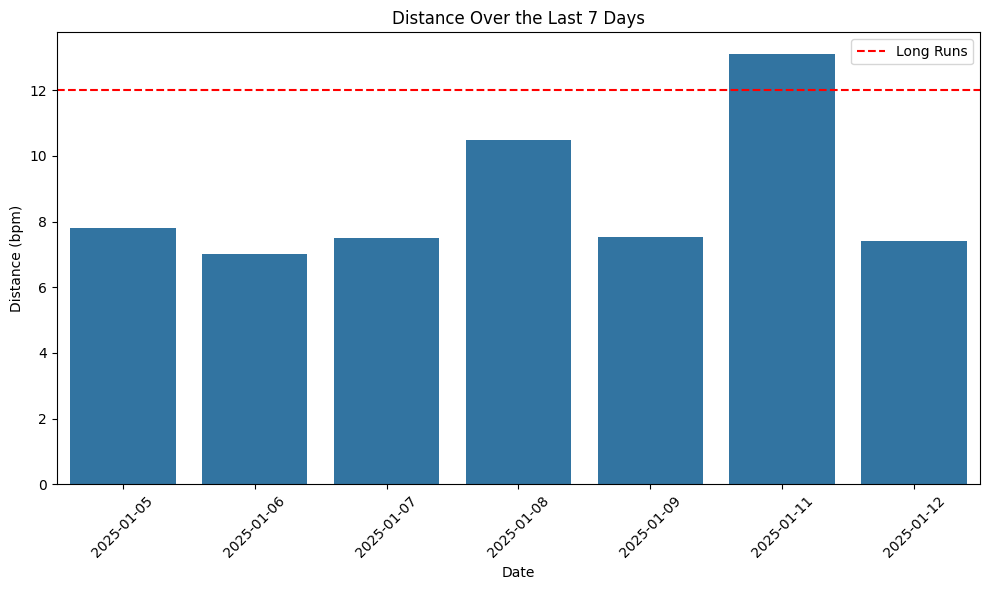

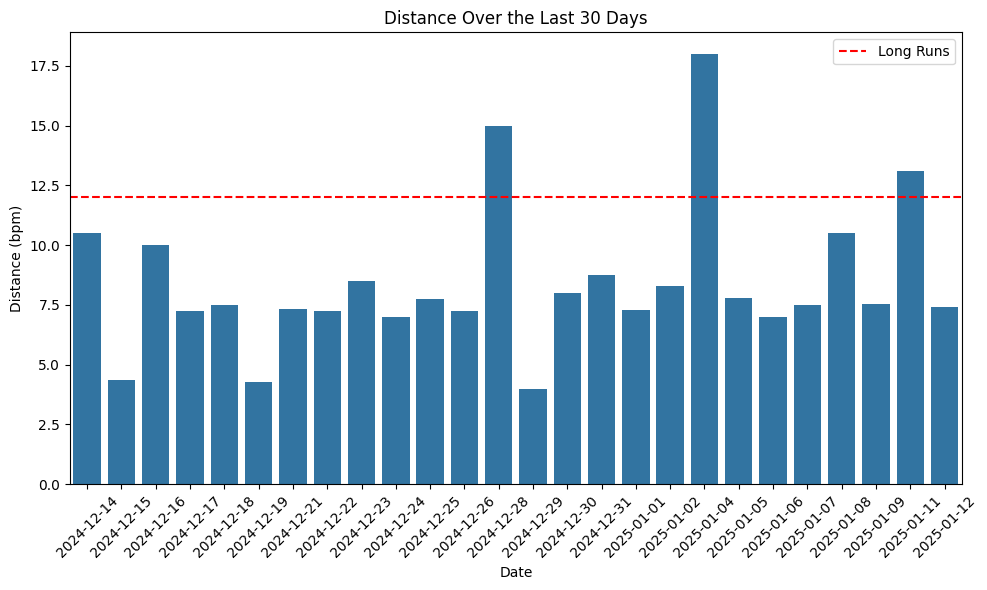

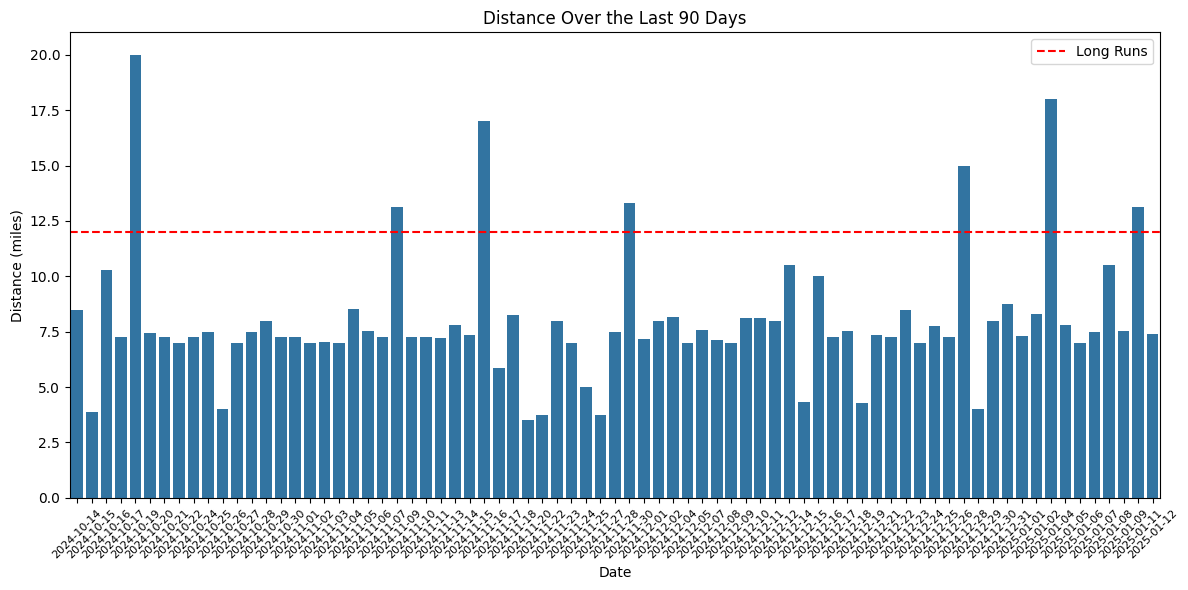

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

# Function to plot bar graph for heart rate over a given period with a horizontal line at 155 bpm
def plot_distance_rate(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average heart rate for each day
    daily_distance_rate = last_days.groupby('Date')['Distance'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Distance', data=daily_distance_rate)
    
    # Add a horizontal line at y=155 bpm
    plt.axhline(y= 12, color='r', linestyle='--', label='Long Runs')
    
    plt.title(f'Distance Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Distance (bpm)')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

# Plot heart rate for the last 7, 30, and 90 days
plot_distance_rate(df, 7, "Last 7 Days")
plot_distance_rate(df, 30, "Last 30 Days")

# Filter data for the last 90 days
last_days = filter_last_days(df, 90)

# Group by date and calculate the average heart rate for each day
daily_distance_rate = last_days.groupby('Date')['Distance'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='Distance', data=daily_distance_rate)

# Add a horizontal line at y=12 (e.g., to denote long runs)
plt.axhline(y=12, color='r', linestyle='--', label='Long Runs')

# Set the plot title and labels
plt.title('Distance Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Distance (miles)')

# Rotate and reduce the font size of date labels
plt.xticks(rotation=45, fontsize=8)

# Add legend and layout adjustments
plt.legend()
plt.tight_layout()
plt.show()


## Weekly and Monthly Milage Calculations 
Calculating weekly and monthly mileage provides a clear picture of my overall training volume and progression. By tracking these metrics, I can ensure I'm gradually increasing my workload to build endurance while minimizing the risk of injury. These calculations also help me assess if I'm meeting my marathon preparation targets and allow me to make data-driven adjustments to maintain consistent performance and recovery balance.

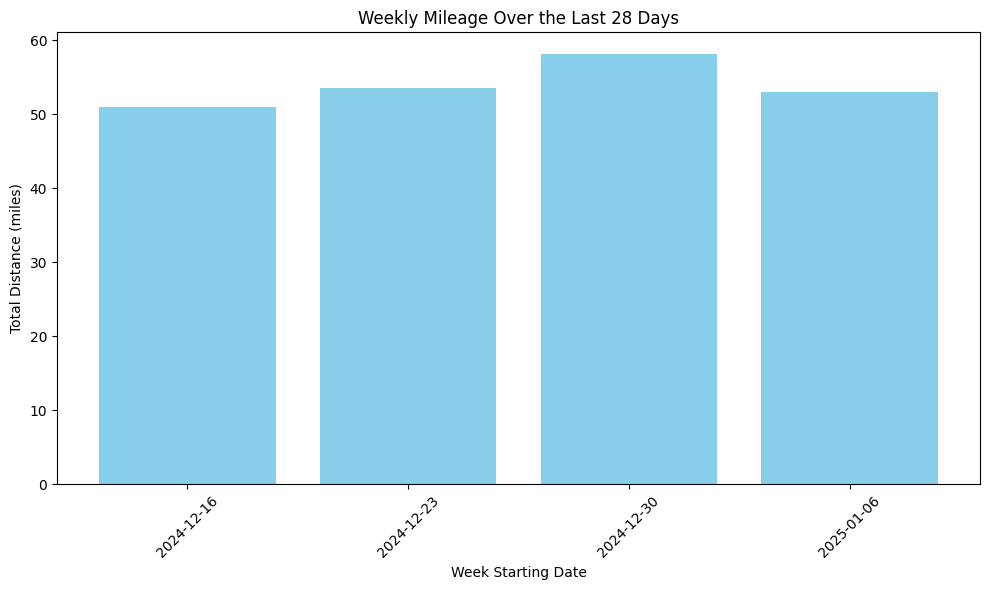

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]


# Assuming you have the function to filter the last N days
# Use your existing function to filter for the last 28 days
last_28_days = filter_last_days(df, 27)

# Ensure that you work with a copy of the DataFrame
last_28_days = last_28_days.copy()

# Use .loc[] to safely assign a new column in the DataFrame
last_28_days.loc[:, 'Week Start'] = last_28_days['Date'] - pd.to_timedelta(last_28_days['Date'].apply(lambda x: pd.Timestamp(x).weekday()), unit='D')

# Group by 'Week Start' and sum the distance for each week
weekly_mileage = last_28_days.groupby('Week Start')['Distance'].sum().reset_index()

# Plotting the weekly mileage as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekly_mileage['Week Start'].astype(str), weekly_mileage['Distance'], color='skyblue')
plt.xlabel('Week Starting Date')
plt.ylabel('Total Distance (miles)')
plt.title('Weekly Mileage Over the Last 28 Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


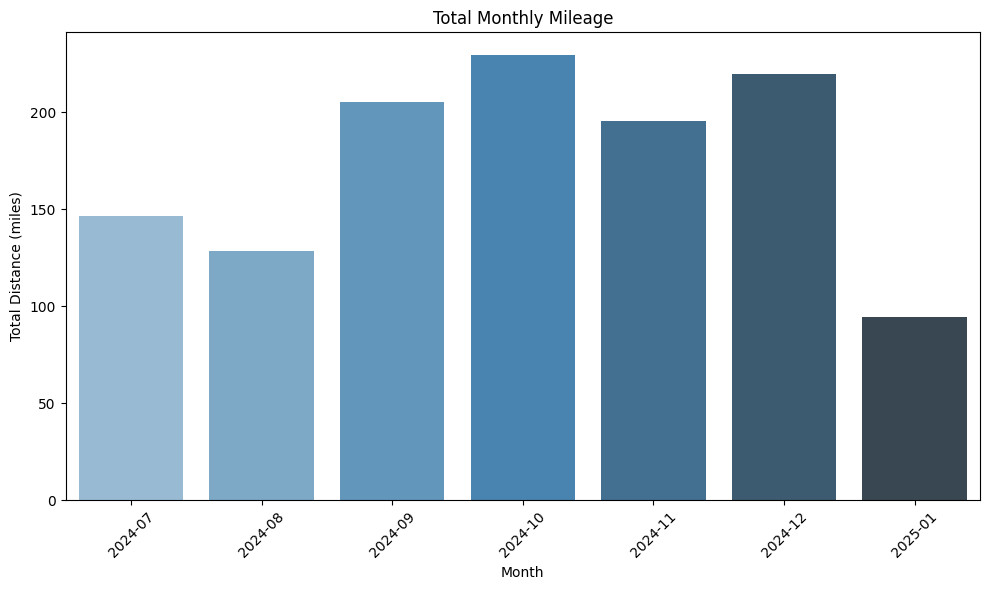

In [62]:
# Assuming df is already loaded and 'Date' is in string format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert 'Date' to datetime

# Filter data for the past 6 months, starting from July 1st
start_of_july = pd.to_datetime('2024-07-01')  # Set the start date to July 1st, 2024
df_last_6_months = df[df['Date'] >= start_of_july].copy()  # Use .copy() to avoid modifying the slice

# Now, use .loc to avoid the SettingWithCopyWarning
df_last_6_months.loc[:, 'Year-Month'] = df_last_6_months['Date'].dt.to_period('M')

# Group by 'Year-Month' and sum the distance for each month
monthly_mileage = df_last_6_months.groupby('Year-Month')['Distance'].sum().reset_index()

# Sort by 'Year-Month'
monthly_mileage = monthly_mileage.sort_values('Year-Month')

# Plotting the monthly mileage bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage, hue='Year-Month', palette='Blues_d', legend=False)
plt.title('Total Monthly Mileage')
plt.xlabel('Month')
plt.ylabel('Total Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

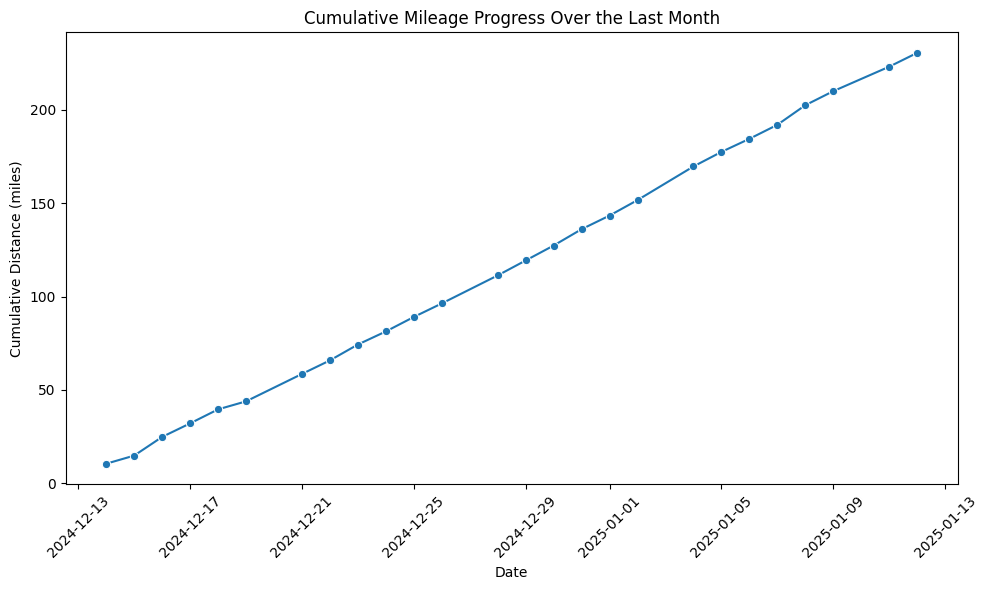

In [63]:
# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 3 months
three_months_ago = pd.to_datetime('today') - pd.DateOffset(months=1)
df_last_3_months = df[df['Date'] >= three_months_ago]

# Group by date and sum the distance for each day
daily_mileage = df_last_3_months.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage over the last 3 months
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.title('Cumulative Mileage Progress Over the Last Month')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### The Journey to 1000 Miles!!
September 1st marked the beginning of training for the Austin Marathon. My goal for the prep was to accumulate 1000 miles. This graph is a reminder of how far I've come since the start. It's been a huge encoruagement. 

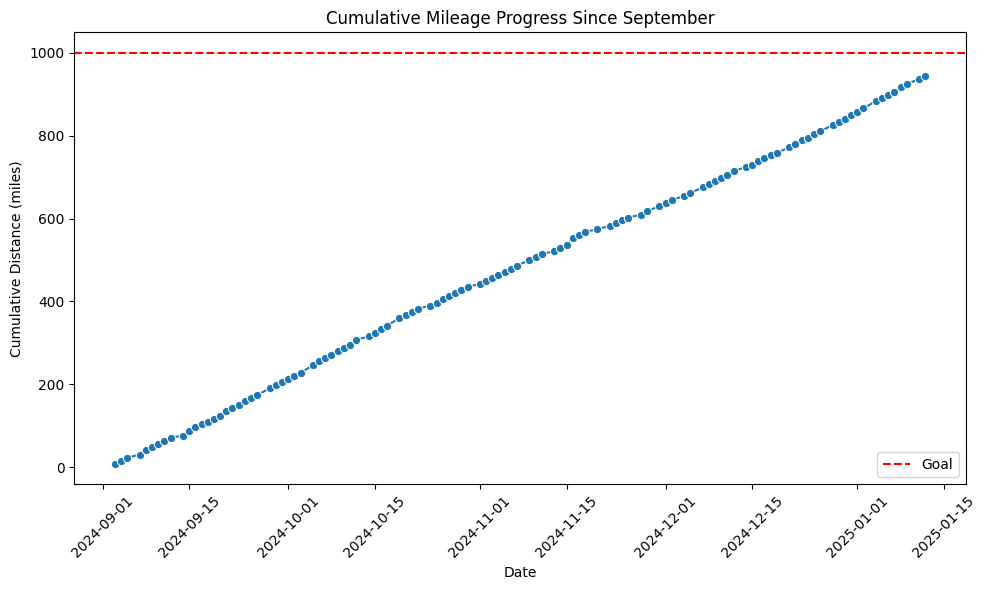

In [64]:

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data since September
september_start = pd.to_datetime('2024-09-01')  # Adjust this to the start date of September
df_since_september = df[df['Date'] >= september_start]

# Group by date and sum the distance for each day
daily_mileage = df_since_september.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage since September
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.axhline(y=1000, color='r', linestyle='--', label='Goal')
plt.title('Cumulative Mileage Progress Since September')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


## Pace and Heart Rate Analysis: Insights from the Past 7 and 30 Days

Monitoring pace and heart rate over the past week and month provides critical insights into my marathon training progress. The primary objective is to improve my ability to sustain faster paces over longer distances while maintaining a lower average heart rate—a key indicator of improved endurance and aerobic efficiency.

My target pace for the Austin Marathon is an average of **8:10 minutes per mile**, aiming for a finishing time of approximately **3:34**. This pace provides a buffer for achieving my ultimate goal of a sub-3:40:00 finish. Consistently training at this pace during longer runs helps simulate race conditions and build confidence in hitting my performance targets.

I calculate my recovery heart rate using the **MAF formula**: 180 minus my age. At 21 years old, my recovery threshold is **159 bpm**. On easy days, I aim to keep my average heart rate below this limit to ensure proper recovery and prevent overtraining. In the early stages of my prep, one of my challenges was training too intensely on recovery days, which led to fatigue and reduced performance. I've since prioritized maintaining low-intensity efforts on recovery days, which is critical for achieving high-mileage weeks while minimizing the risk of injury or burnout.

By consistently tracking these metrics, I can fine-tune my training approach, balance effort with recovery, and optimize my performance as race day approaches.


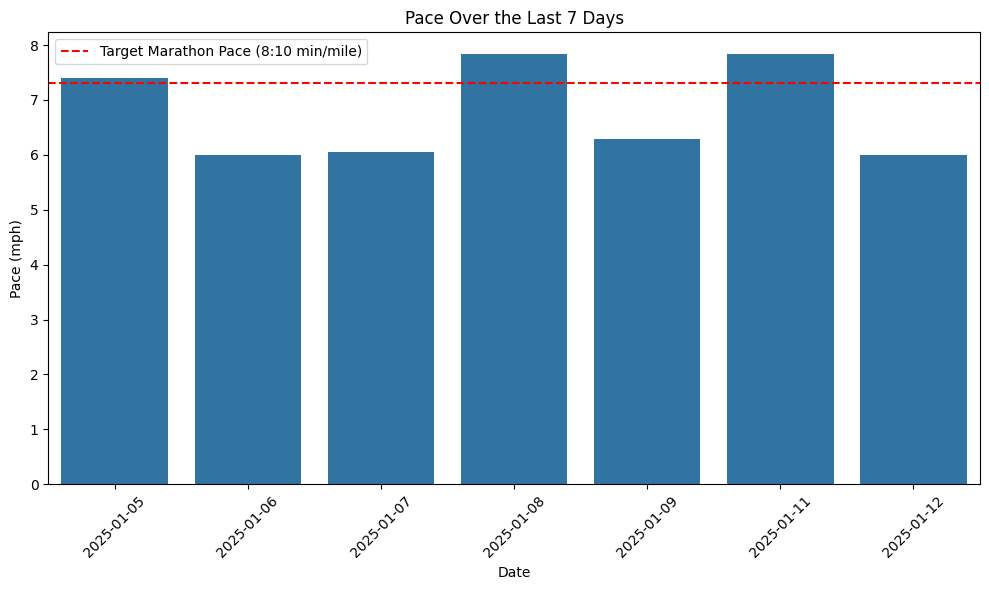

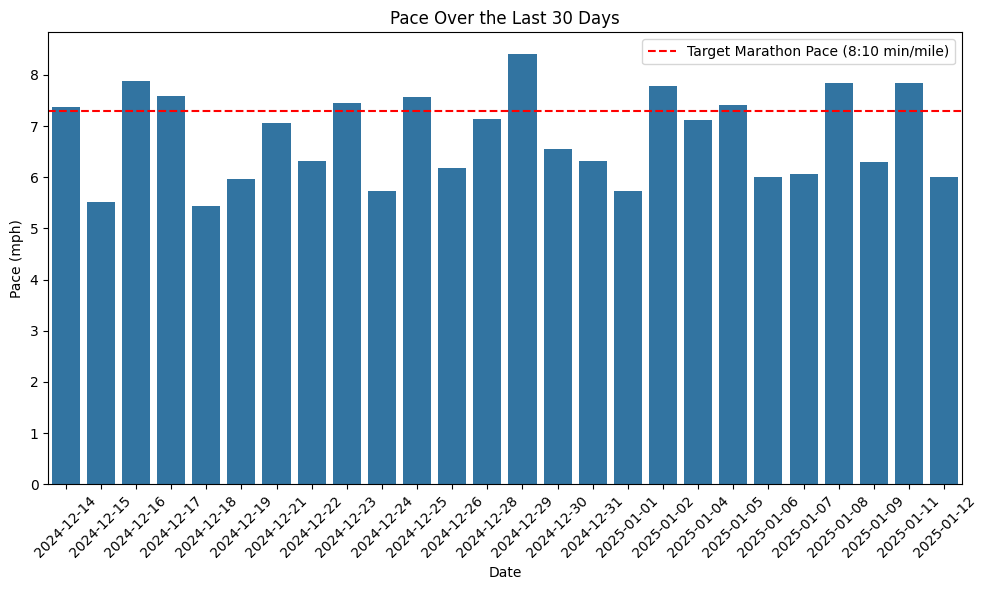

In [65]:
# Function to filter data for the last X days
def filter_last_days(df, days):
    most_recent_date = df['Date'].max()
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

# Function to plot bar graph for pace over a given period
def plot_pace(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average pace for each day
    daily_pace = last_days.groupby('Date')['Pace (mph)'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Pace (mph)', data=daily_pace)
    plt.title(f'Pace Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Pace (mph)')
    plt.axhline(y=7.3, color='r', linestyle='--', label='Target Marathon Pace (8:10 min/mile)')
    plt.legend()  # Show the legend for the line
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Plot pace for the last 7, 30, and 90 days
plot_pace(df, 7, "Last 7 Days")
plot_pace(df, 30, "Last 30 Days")


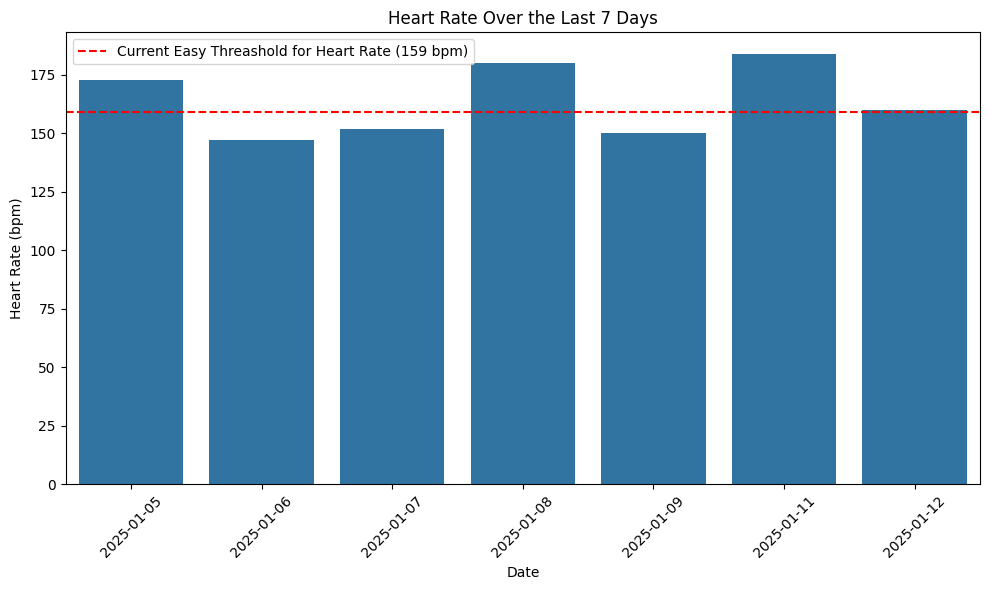

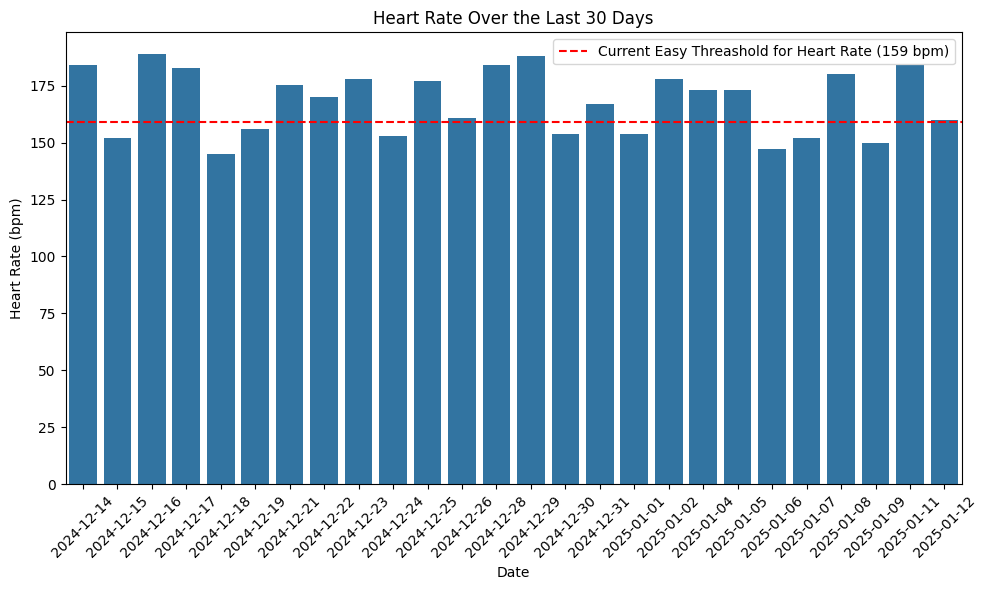

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot bar graph for heart rate over a given period with a horizontal line at 155 bpm
def plot_heart_rate(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Group by date and calculate the average heart rate for each day
    daily_heart_rate = last_days.groupby('Date')['Heart Rate'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Heart Rate', data=daily_heart_rate)
    
    # Add a horizontal line at y=155 bpm
    plt.axhline(y=159, color='r', linestyle='--', label='Current Easy Threashold for Heart Rate (159 bpm)')
    
    plt.title(f'Heart Rate Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Heart Rate (bpm)')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

# Plot heart rate for the last 7, 30, and 90 days
plot_heart_rate(df, 7, "Last 7 Days")
plot_heart_rate(df, 30, "Last 30 Days")



In [67]:
# import matplotlib.pyplot as plt

# # Calculate and display correlation for the last 7 days
# correlation_7_days = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 7 days: {correlation_7_days:.2f}")

# # Calculate and display correlation for the last 30 days
# correlation_30_days = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 30 days: {correlation_30_days:.2f}")

# # Calculate and display correlation for the last 90 days
# correlation_90_days = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# print(f"Correlation between Pace and Heart Rate over the last 90 days: {correlation_90_days:.2f}")
 
# # Scatter Plot: Pace vs Heart Rate for the Last 7 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_7_days)
# plt.correlation = last_7_days['Pace (mph)'].corr(last_7_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 7 Days\nCorrelation: {correlation_7_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_30_days)
# plt.correlation = last_30_days['Pace (mph)'].corr(last_30_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 30 Days\nCorrelation: {correlation_30_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 

# # Scatter Plot: Pace vs Heart Rate for the Last 30 Days
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_90_days)
# plt.correlation = last_90_days['Pace (mph)'].corr(last_90_days['Heart Rate'])
# plt.title(f'Pace vs Heart Rate Over the Last 90 Days\nCorrelation: {correlation_90_days:.2f}')
# plt.xlabel('Pace (min/mile)')
# plt.ylabel('Heart Rate (bpm)')
# plt.grid(True)
# plt.tight_layout()
# plt.show() 


### Rolling Performance Scores: Last 7 and 30 Days

The rolling performance score tracks my workout performance over specific periods (7 and 30 days) to provide insights into how consistently I'm improving. By calculating my pace, heart rate, and distance over these intervals, the performance score gives me a clear picture of my training intensity, efficiency, and progress. This helps in identifying trends in my training, ensuring I’m training effectively, and making adjustments when necessary. Below are the rolling performance scores for the past 7 and 30 days.

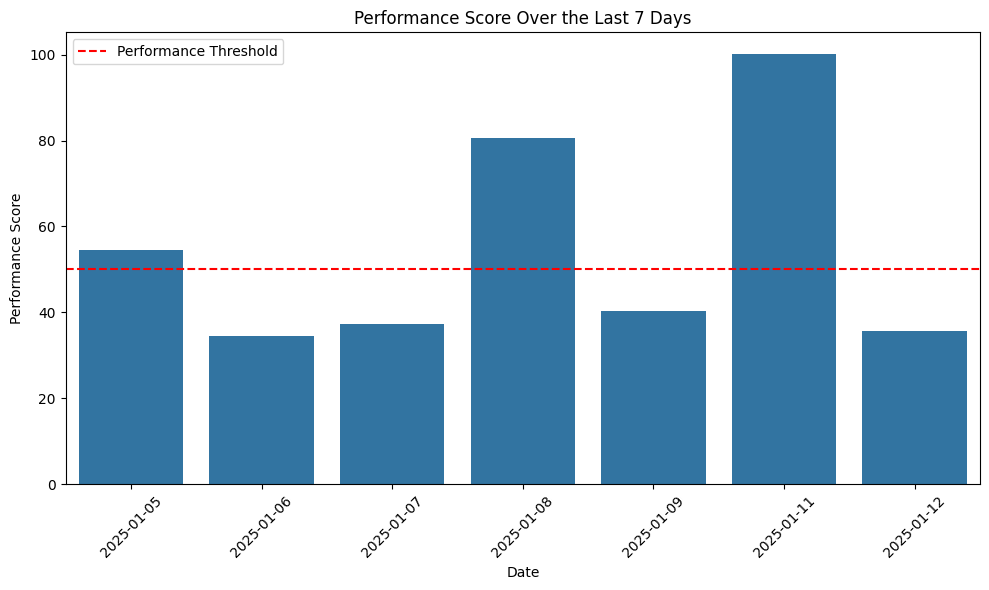

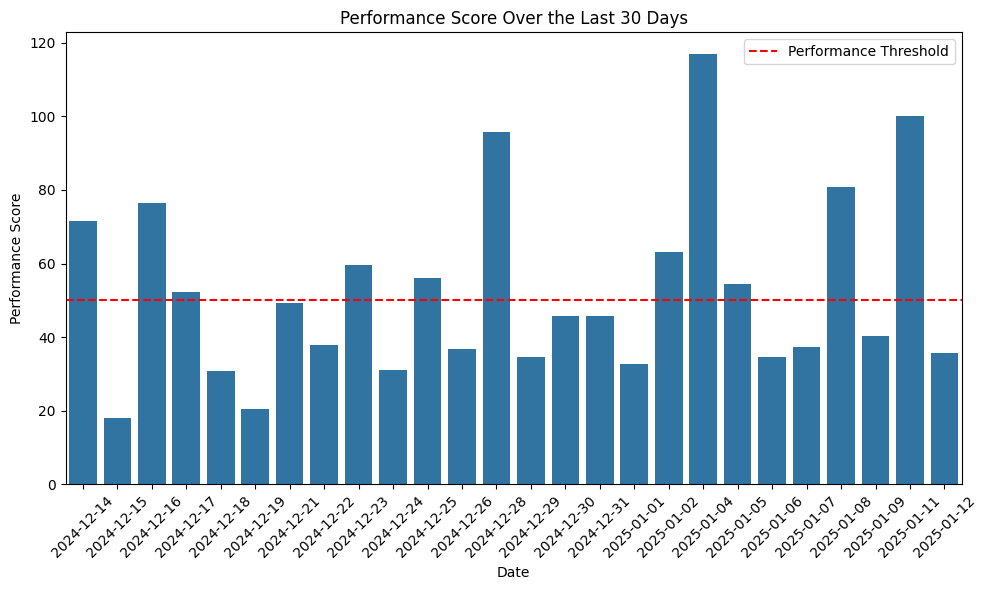

In [68]:
# Function to calculate performance score
def calculate_performance_score(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0:
        return None  # Handle division by zero

    performance_score = (
        (pace ** 1.9)          # Heavily reward faster paces
        * ((distance ** 1) / 1.3)  # Strongly reward longer distances
        / (heart_rate ** 0.31)  # Minimally penalize higher heart rate
    )
    return performance_score

def plot_performance_score(df, days, time_period="Last X Days"):
    last_days = filter_last_days(df, days)
    
    # Instead of setting directly on the slice, use .loc to avoid the warning
    last_days = last_days.copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    last_days['Performance Score'] = last_days.apply(
        lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1
    )
    
    # Group by date and calculate the average performance score for each day
    daily_performance_score = last_days.groupby('Date')['Performance Score'].mean().reset_index()
    
        # Sort the entries by 'Performance Score' in descending order to get the top performances
    top_performances = last_days.sort_values(by='Performance Score', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Date', y='Performance Score', data=daily_performance_score)
    
    # Add a horizontal line for a certain threshold (adjust threshold as needed)
    plt.axhline(y=50, color='r', linestyle='--', label='Performance Threshold')
    
    plt.title(f'Performance Score Over the {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.legend()  # Show the legend for the line
    plt.tight_layout()
    plt.show()

## Plot performance score for the last 7, 30, and 90 days
plot_performance_score(df, 7, "Last 7 Days")
plot_performance_score(df, 30, "Last 30 Days")

### Top 10 Performances

In this section, I’ve highlighted my top 10 performances based on a custom performance score, which factors in my pace, heart rate, and distance. This score helps me assess the overall quality of my workouts, emphasizing faster paces, longer distances, and efficient heart rate management. By identifying my best performances, I can better track progress and focus on improving in key areas for future runs. Below are the top 10 performances from my running history based on this score.


In [69]:
def display_top_performances(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df = df.copy()

    # Apply the performance score function to the data
    df['Performance Score'] = df.apply(
        lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1
    )

    # Sort by Performance Score in descending order and get the top 10
    top_10_performances = df.sort_values(by='Performance Score', ascending=False).head(10)

    display(top_10_performances[['Date', 'Title', 'Distance', 'Pace (mph)', 'Heart Rate', 'Performance Score']])

# Example usage:
# Display the top 10 performances
display_top_performances(df)

,Date,Title,Distance,Pace (mph),Heart Rate,Performance Score
77,2024-10-19,GINOBILI,20.01,6.824176,162,122.193886
90,2024-10-05,Get Lucky,18.01,7.096760,168,117.149035
7,2025-01-04,Wins & Loses,18.00,7.128713,173,117.018895
52,2024-11-16,POWER,17.01,7.108893,173,109.999413
98,2024-09-28,Psychotron,16.01,6.960870,157,102.513186
1,2025-01-11,Afraid to Feel,13.11,7.839867,184,100.173384
39,2024-11-30,Monster,13.30,7.682927,179,98.633529
33,2024-12-07,Peak,13.13,7.675869,181,96.868672
14,2024-12-28,Why is it 80 and sunny in december?,15.00,7.129654,184,95.693944
20,2024-12-21,JW Half,13.67,7.386971,188,92.666416


## Training Stress Score (TSS)

The **Training Stress Score (TSS)** is used to quantify the intensity and duration of a workout, combining both the time spent and the workout's intensity. The formula for calculating TSS is:

$$
TSS = \left( \frac{{\text{Duration} \times \text{Intensity Factor (IF)}}}{{\text{FTP}}} \right) \times 100
$$

Where:

- **Duration**: The time of the workout (in hours or minutes).
- **Intensity Factor (IF)**: The ratio of normalized power to functional threshold power (FTP) or normalized pace to threshold pace.
- **FTP (Functional Threshold Power)**: The power or pace you can sustain for about an hour at maximum effort. For runners, FTP is often equated to your threshold pace (the pace at which you can run for an hour).
  
## Acute Training Load (ATL) and Chronic Training Load (CTL)

**Acute Training Load (ATL)** and **Chronic Training Load (CTL)** are values that measure the impact of your training over different time frames.

- **ATL (Acute Training Load)**: The 7-day rolling average of TSS, providing an indication of how hard your recent workouts have been.
  
- **CTL (Chronic Training Load)**: The 28-day rolling average of TSS, reflecting long-term fitness and consistency in your training regimen.

Together, ATL and CTL help you understand how your body is adapting to your training and whether you're at risk of overtraining or undertraining.


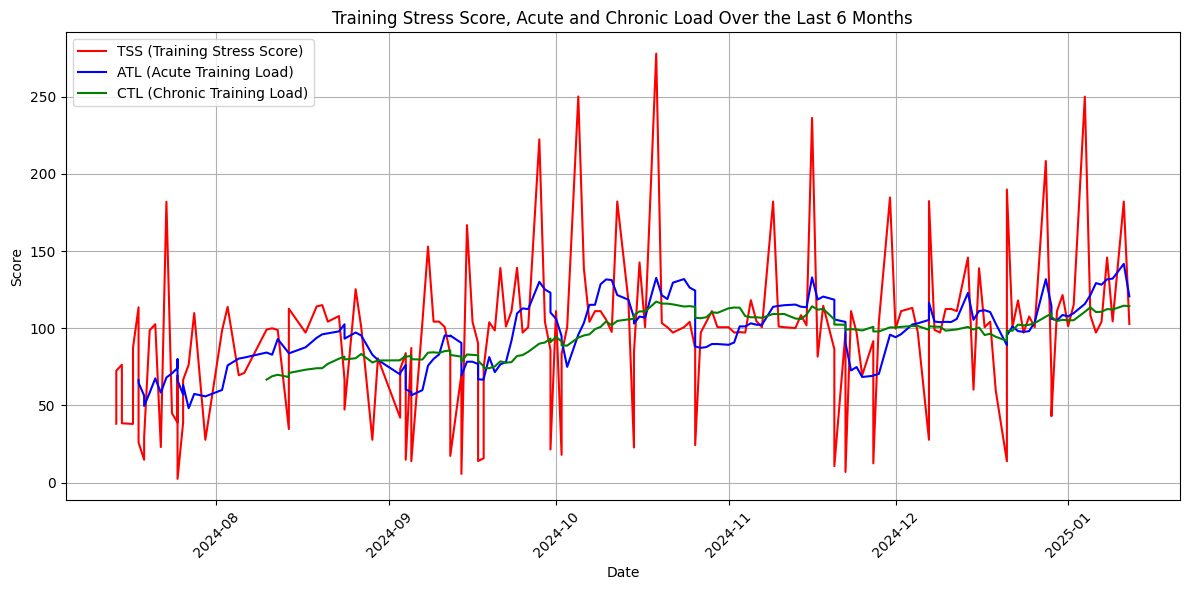

In [70]:
# Assuming you already have a dataframe df with 'Date', 'Distance', 'Pace (mph)', 'Heart Rate'
# You can add your threshold pace value (FTP) here
threshold_pace = 7.2  # e.g., threshold pace of 6 mph (adjust according to your actual pace)

# Filter the data to include only the last 6 months
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=6)
df_last_6_months = df[df['Date'] >= six_months_ago]
df_last_6_months = df_last_6_months.copy()

# Function to calculate TSS (Training Stress Score)
def calculate_tss(distance, pace, duration, threshold_pace):
    intensity_factor = pace / threshold_pace  # Calculate intensity factor based on pace
    tss = (duration * intensity_factor) * 100  # TSS formula
    return tss

# Calculate Duration (time in hours) for each row in the dataframe
df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']

# Calculate TSS for each run
df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)

# Calculate the 7-day (ATL) and 28-day (CTL) rolling averages of TSS
df_last_6_months['ATL'] = df_last_6_months['TSS'].rolling(window=7).mean()
df_last_6_months['CTL'] = df_last_6_months['TSS'].rolling(window=28).mean()

# Plot the TSS, ATL, and CTL over time for the last 6 months
plt.figure(figsize=(12, 6))

plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS (Training Stress Score)', color='red')
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL'], label='ATL (Acute Training Load)', color='blue')
plt.plot(df_last_6_months['Date'], df_last_6_months['CTL'], label='CTL (Chronic Training Load)', color='green')

plt.title('Training Stress Score, Acute and Chronic Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


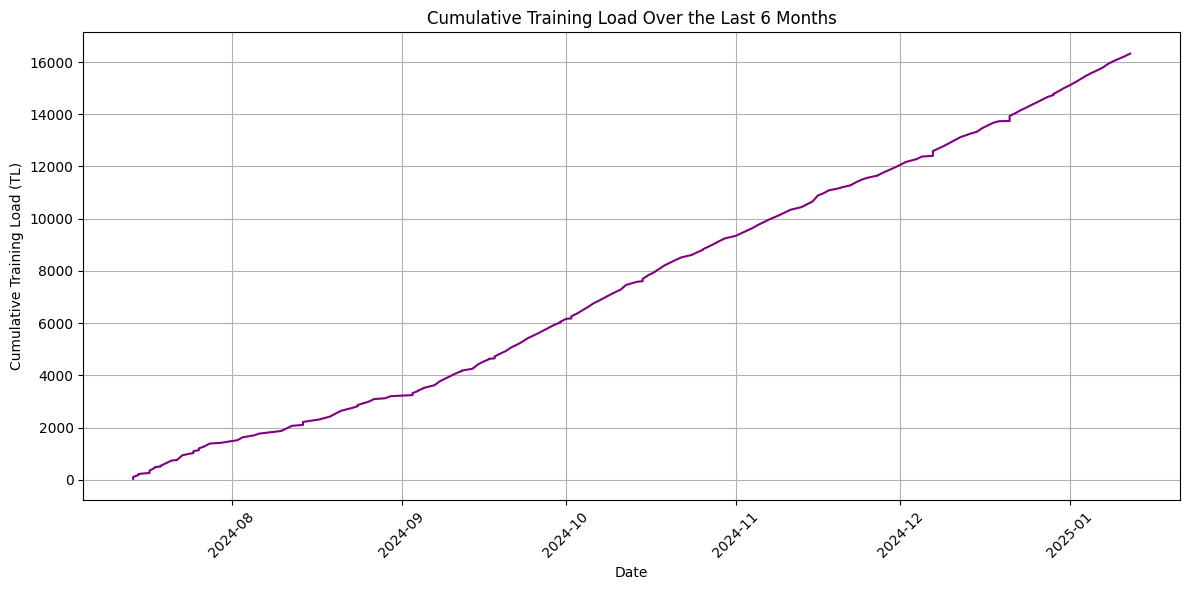

In [71]:
# Calculate cumulative training load (sum of TSS values)
df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()

# Plot Cumulative Training Load
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Cumulative TL'], label='Cumulative Training Load', color='purple')
plt.title('Cumulative Training Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Training Load (TL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Intensity Factor (IF)

The **Intensity Factor (IF)** is a metric used to express the intensity of a workout relative to your threshold. It provides a more specific measure of how hard the workout was compared to your typical capability. For runners, the Intensity Factor is calculated as:

$$
IF = \frac{{\text{Actual Pace}}}{{\text{Threshold Pace}}}
$$

Where:

- **Actual Pace**: The pace at which you completed the workout.
- **Threshold Pace**: The pace you can sustain for about an hour at maximum effort (typically your Functional Threshold Pace or FTP).

The **Intensity Factor** helps you understand how much you're pushing yourself during a workout compared to your usual running capability, offering a clearer picture of your effort levels. A higher IF indicates a more intense workout, while a lower IF suggests a workout that is closer to your normal pace.


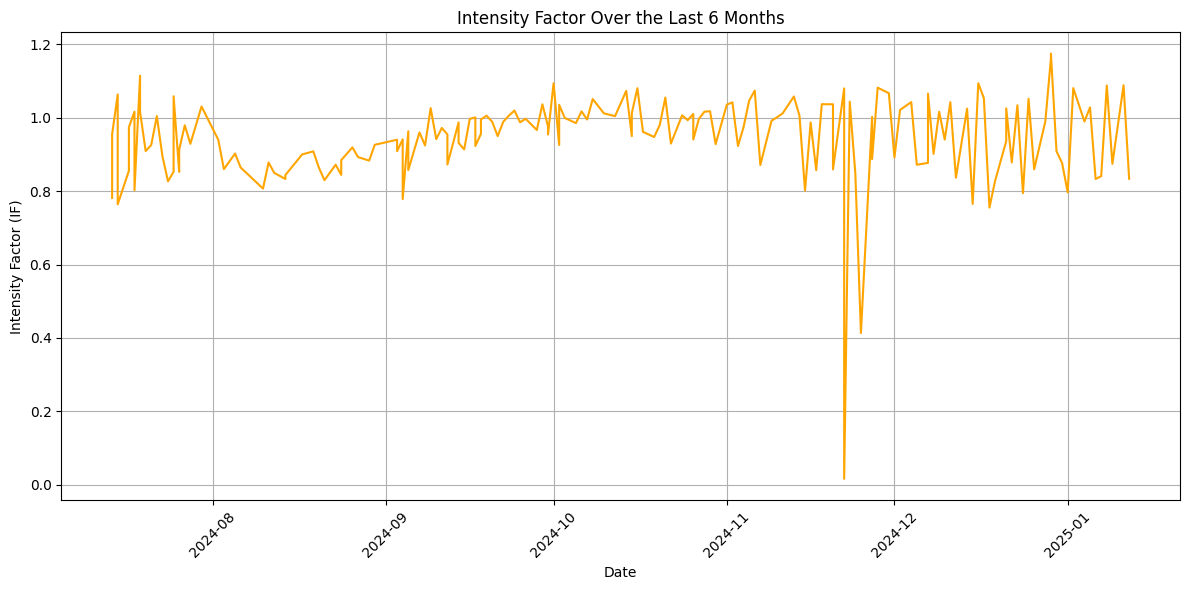

In [72]:
threshold_pace = 7.2

# Calculate Intensity Factor (IF)
df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace

# Plot IF over time
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Intensity Factor'], label='Intensity Factor (IF)', color='orange')
plt.title('Intensity Factor Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Intensity Factor (IF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Acute vs Chronic Load Comparison: 
I can plot the difference between Acute Training Load (ATL) and Chronic Training Load (CTL) over time to identify potential periods of overtraining or when I might need more recovery. If ATL consistently exceeds CTL, it could indicate that I've been pushing myself too hard recently, which may lead to fatigue or a higher risk of injury. Monitoring this balance helps me optimize my training load, avoid burnout, and ensure I'm allowing for enough recovery.


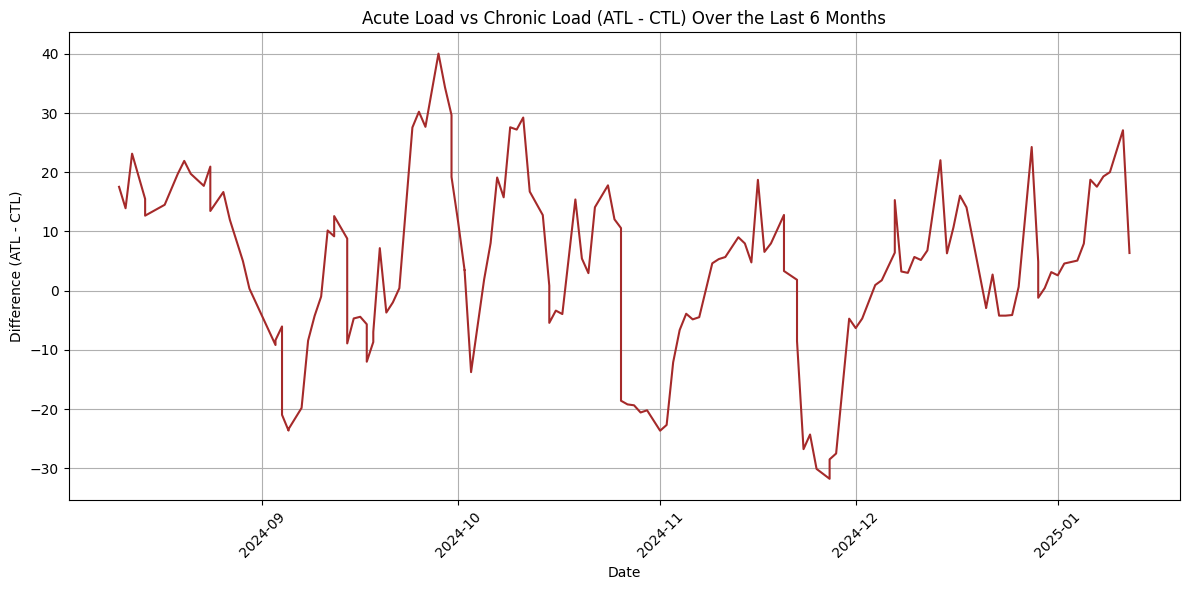

In [73]:
# Calculate ATL - CTL difference
df_last_6_months['ATL - CTL Difference'] = df_last_6_months['ATL'] - df_last_6_months['CTL']

# Plot ATL vs CTL difference
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL - CTL Difference'], label='ATL - CTL Difference', color='brown')
plt.title('Acute Load vs Chronic Load (ATL - CTL) Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Difference (ATL - CTL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Training Peaks: 
Peaks will help me spot high-intensity sessions that may require more recovery.

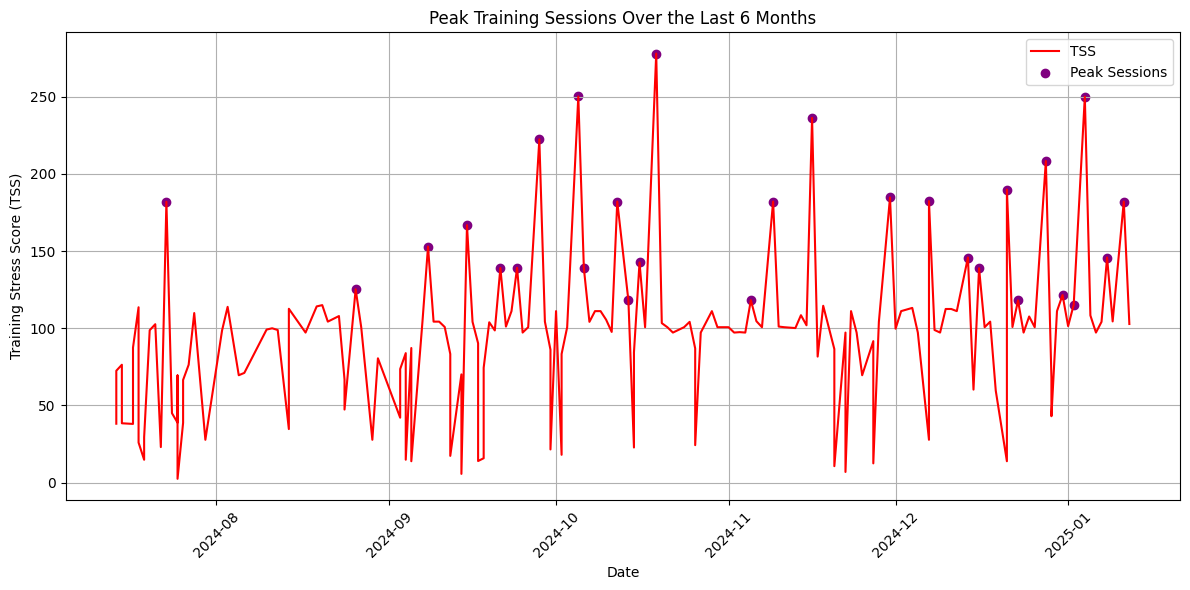

In [74]:
# Define a threshold for peak training sessions (e.g., TSS > 100)
peak_sessions = df_last_6_months[df_last_6_months['TSS'] > 115]

# Plot peak sessions
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS', color='red')
plt.scatter(peak_sessions['Date'], peak_sessions['TSS'], color='purple', label='Peak Sessions')
plt.title('Peak Training Sessions Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Training Stress Score (TSS)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Peak Training Sessions within the past month

In [75]:
today = pd.to_datetime('today')  # Get today's date
past_30_days = today - pd.Timedelta(days=30)  # Calculate the date 30 days ago

# Filter the DataFrame for sessions in the past 30 days
recent_sessions = peak_sessions[peak_sessions['Date'] >= past_30_days]

# Display the relevant columns for the past 30 days, in reverse order (most recent first)
display(recent_sessions[['Date', 'Title', 'TSS', 'Distance', 'Pace (mph)', 'Heart Rate']].iloc[::-1])

,Date,Title,TSS,Distance,Pace (mph),Heart Rate
1,2025-01-11,Afraid to Feel,182.083333,13.11,7.839867,184
3,2025-01-08,Barbra Streisand,145.833333,10.50,7.835821,180
7,2025-01-04,Wins & Loses,250.000000,18.00,7.128713,173
8,2025-01-02,Cheeky Progression🙂,115.138889,8.29,7.784038,178
10,2024-12-31,400m x 10,121.527778,8.75,6.312625,167
14,2024-12-28,Why is it 80 and sunny in december?,208.333333,15.00,7.129654,184
18,2024-12-23,DOMS,118.055556,8.50,7.447067,178
20,2024-12-21,JW Half,189.861111,13.67,7.386971,188
25,2024-12-16,Detached,138.888889,10.00,7.879186,189


## Stress/Rest Ratio
This can be calculated as the ratio of the acute load (ATL) to chronic load (CTL). It provides an indication of how well-balanced my training and recovery are. A high ATL/CTL ratio might indicate I am not recovering enough and could be at risk for overtraining.

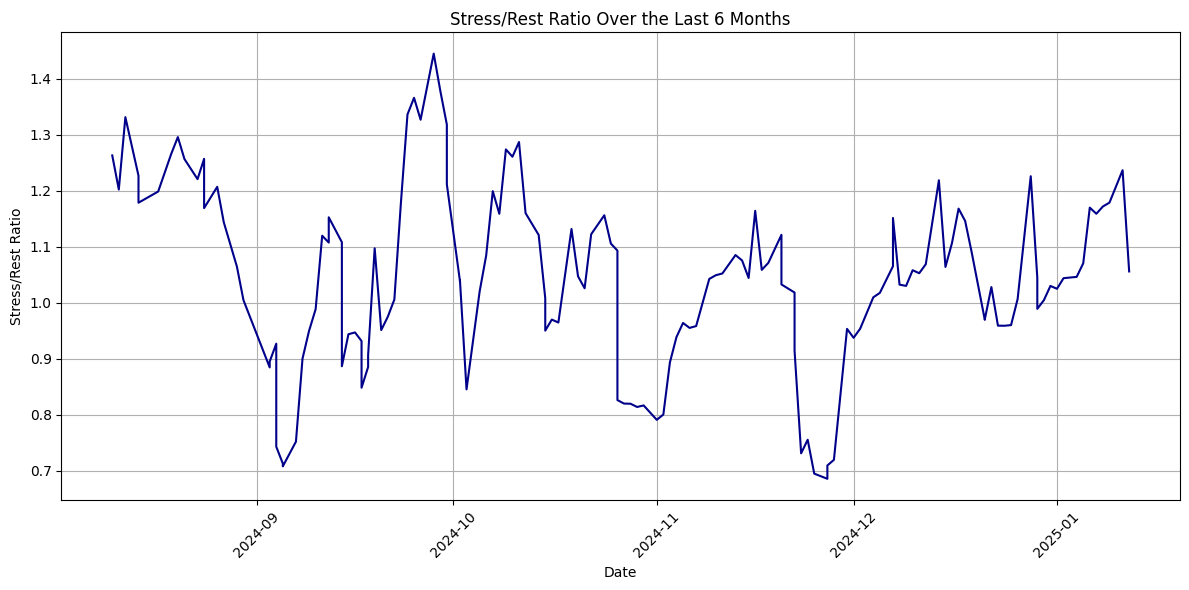

In [76]:
# Calculate Stress/Rest ratio
df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']

# Plot Stress/Rest Ratio
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Stress/Rest Ratio'], label='Stress/Rest Ratio', color='darkblue')
plt.title('Stress/Rest Ratio Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Stress/Rest Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
